# Nuclei segmentation using cellpose

This tutorial shows how we can easily use an external segmentation packages in the *Squidpy* framework.

In [1]:
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt

## Prepare cellpose functionality for *Squidpy*

To use the cellpose package, we need to install it with `pip install cellpose`.
For details on the segmentation model, see: Stringer, Carsen, et al. "Cellpose: a generalist algorithm for cellular segmentation." Nature Methods (2021).
Or check out https://github.com/MouseLand/cellpose for the python implementation.

In [2]:
# Import the cellpose segmentation model. See https://cellpose.readthedocs.io/en/latest/api.html#cellpose-class.

from cellpose import models

The method parameter of the `sq.im.segment` method accepts any callable with the signature:
`numpy.ndarray` (height, width, channels) -> `numpy.ndarray` (height, width[, channels]).
Additional model specific arguments will also be passed on.
To use the cellpose model, we define a wrapper that initializes the model, evaluates it and returns the
segmentation mask. We can make use of cellpose specific options by passing on arguments like the minimum
number of pixels per mask `min_size`.

In [3]:
# Wrap the cellpose model initialization and evaluation into one method that we can then pass on to the segmentation
# framework of Squidpy.

def cellpose(img, min_size=15):
    model = models.Cellpose(model_type='nuclei')
    res, _, _, _ = model.eval(
        img, 
        channels=[0, 0], 
        diameter=None, 
        min_size=min_size,
    )
    return res

## Cell segmentation on visium fluorescence data

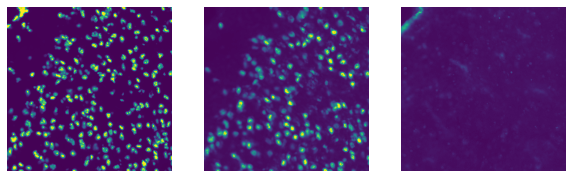

In [4]:
# Load the image and visualize its channels. We will use the first channel for segmentation.

img = sq.datasets.visium_fluo_image_crop()
crop = img.crop_corner(1000, 1000, size=1000)

fig, axes = plt.subplots(1, 3, figsize=(10, 20))
for i, ax in enumerate(axes):
    crop.show("image", channel=i, ax=ax)

In [5]:
# Segment the image using the cellpose function defined above. Cellpose can incorporate multiple channels,
# but we will only use the DAPI channel.

sq.im.segment(img=crop, layer="image", channel=0, method=cellpose)

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 331


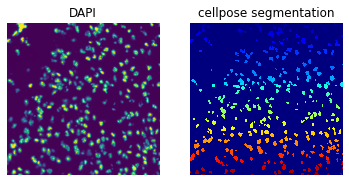

In [6]:
# Plot the DAPI channel of the image crop and the segmentation result.

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("cellpose segmentation")

The `sq.im.segment` method will pass any additional arguments to the cellpose function, 
so we can also filter out segments with less than 200 pixels and compare the results to the
segmentation result from above that works with the default of 15 pixels.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 187


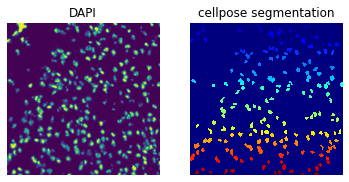

In [7]:
sq.im.segment(img=crop, layer="image", channel=0, method=cellpose, min_size=200)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("cellpose segmentation")

## Cell segmentation on H&E stained tissue data

We can also apply this model to H&E images, but here we need to invert the color values.
We could include this parameter into our cellpose function, but decided to hardcode it in a new function.
Additionally, we found that the naïve usage will recognize only few of the cells and extended the arguments we
allow for cellpose by `flow_threshold`.

In [8]:
def cellpose_hne(img, min_size=15, flow_threshold=0.4):
    model = models.Cellpose(model_type='nuclei')
    res, _, _, _ = model.eval(
        img, 
        channels=[0, 0], 
        diameter=None, 
        min_size=min_size,
        invert=True,
        flow_threshold=flow_threshold,
    )
    return res

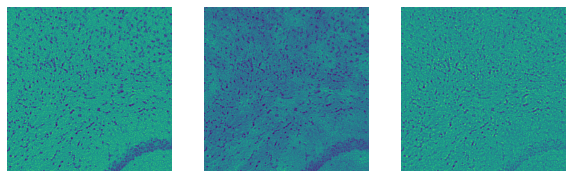

In [9]:
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)

fig, axes = plt.subplots(1, 3, figsize=(10, 20))
for i, ax in enumerate(axes):
    crop.show("image", channel=i, ax=ax)

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 714


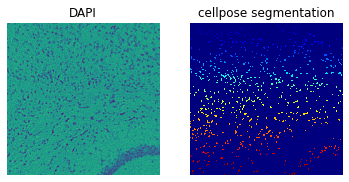

In [10]:
# Cellpose segmentation with the default value flow_threshold=0.4.

sq.im.segment(img=crop, layer="image", channel=0, method=cellpose_hne)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("cellpose segmentation")

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 963


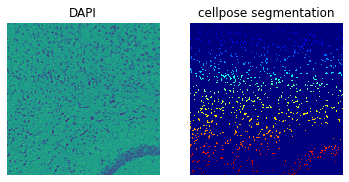

In [11]:
# We can detect significantly more nuclei with an increased flow_threshold value.

sq.im.segment(img=crop, layer="image", channel=0, method=cellpose_hne, flow_threshold=0.8)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("cellpose segmentation")